In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")


data = train.merge(features, on=['Store','Date'], how='left')
data = data.merge(stores, on='Store', how='left')

data['IsHoliday'] = data.get('IsHoliday', False)
for col in ['Temperature','Fuel_Price','CPI','Unemployment']:
    data[col] = data.get(col, 0)
data['Type'] = data.get('Type', 'A')


In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Store','Dept','Date']).reset_index(drop=True)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week
data['DayOfWeek'] = data['Date'].dt.dayofweek

for lag in [1,2,3,4]:
    data[f'Lag_{lag}'] = data.groupby(['Store','Dept'])['Weekly_Sales'].shift(lag)
for window in [4,8,12]:
    data[f'Rolling_{window}'] = data.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(window).mean()


In [11]:
data = data.dropna().reset_index(drop=True)

cap = data['Weekly_Sales'].quantile(0.99)
data['Weekly_Sales'] = np.where(data['Weekly_Sales']>cap, cap, data['Weekly_Sales'])

feature_cols = ['Store','Dept','Temperature','Fuel_Price','CPI','Unemployment',
                'Year','Month','Week','DayOfWeek','IsHoliday','Type'] + \
               [f'Lag_{i}' for i in [1,2,3,4]] + \
               [f'Rolling_{w}' for w in [4,8,12]]

X = data[feature_cols]
y = data['Weekly_Sales']

X = pd.get_dummies(X, columns=[c for c in ['Type','IsHoliday'] if c in X.columns], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
tscv = TimeSeriesSplit(n_splits=5)
elastic_rmse = []
lgb_rmse = []

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    en = ElasticNetCV(l1_ratio=[0.1,0.5,0.7,0.9,1.0], alphas=np.logspace(-2,2,50),
                      max_iter=20000, cv=3, random_state=42)
    en.fit(X_train, y_train)
    y_pred_en = en.predict(X_test)
    elastic_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_en)))

    lgb = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=10,
        min_data_in_leaf=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    lgb.fit(X_train, y_train)
    y_pred_lgb = lgb.predict(X_test)
    lgb_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_lgb)))


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 16108, number of used features: 17
[LightGBM] [Info] Start training from score 20105.687176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

ElasticNet RMSE per fold: [np.float64(6738.903201553314), np.float64(7332.352406346188), np.float64(6205.41284270745), np.float64(5713.481680265838), np.float64(5368.615139836411)]
LightGBM RMSE per fold: [np.float64(4278.652470414468), np.float64(3901.889874081829), np.float64(3135.814243630649), np.float64(3082.825748107574), np.float64(2594.7054887105187)]
Average ElasticNet RMSE: 6271.75305414184
Average LightGBM RMSE: 3398.7775649890077


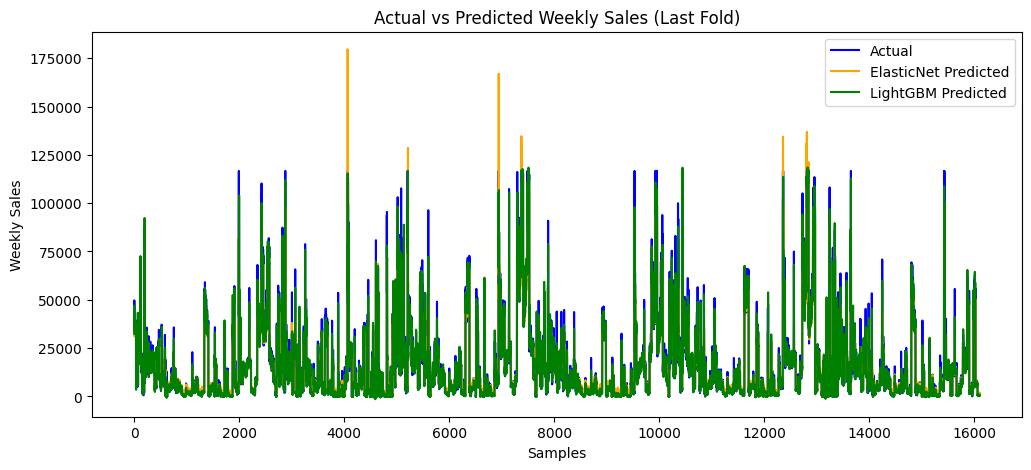

In [16]:
print("ElasticNet RMSE per fold:", elastic_rmse)
print("LightGBM RMSE per fold:", lgb_rmse)
print("Average ElasticNet RMSE:", np.mean(elastic_rmse))
print("Average LightGBM RMSE:", np.mean(lgb_rmse))

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_en, label='ElasticNet Predicted', color='orange')
plt.plot(y_pred_lgb, label='LightGBM Predicted', color='green')
plt.title('Actual vs Predicted Weekly Sales (Last Fold)')
plt.xlabel('Samples')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()
